# Recovering Telomere-to-Telomere Contigs

**You need Verkko version > 0.1.12 for this tutorial**

After building the Verkko assembly, we can check how many contigs have telomeres at both ends to determine if the assembly is truly T2T (telomere-to-telomere). Ideally, most contigs should have telomeres, but don’t worry if some do not. In this section, we introduce several cases where you can recover T2T contigs.

We will cover three different scenarios:

* Case 1: A single contig was mistakenly split into two, but chromosome assignment information is available.      
* Case 2: A single contig was mistakenly split into two, but chromosome assignment information is missing for the shorter contig.        
* Case 3: Artificial sequences were added beyond the real telomere, preventing telomere detection at the ends.      

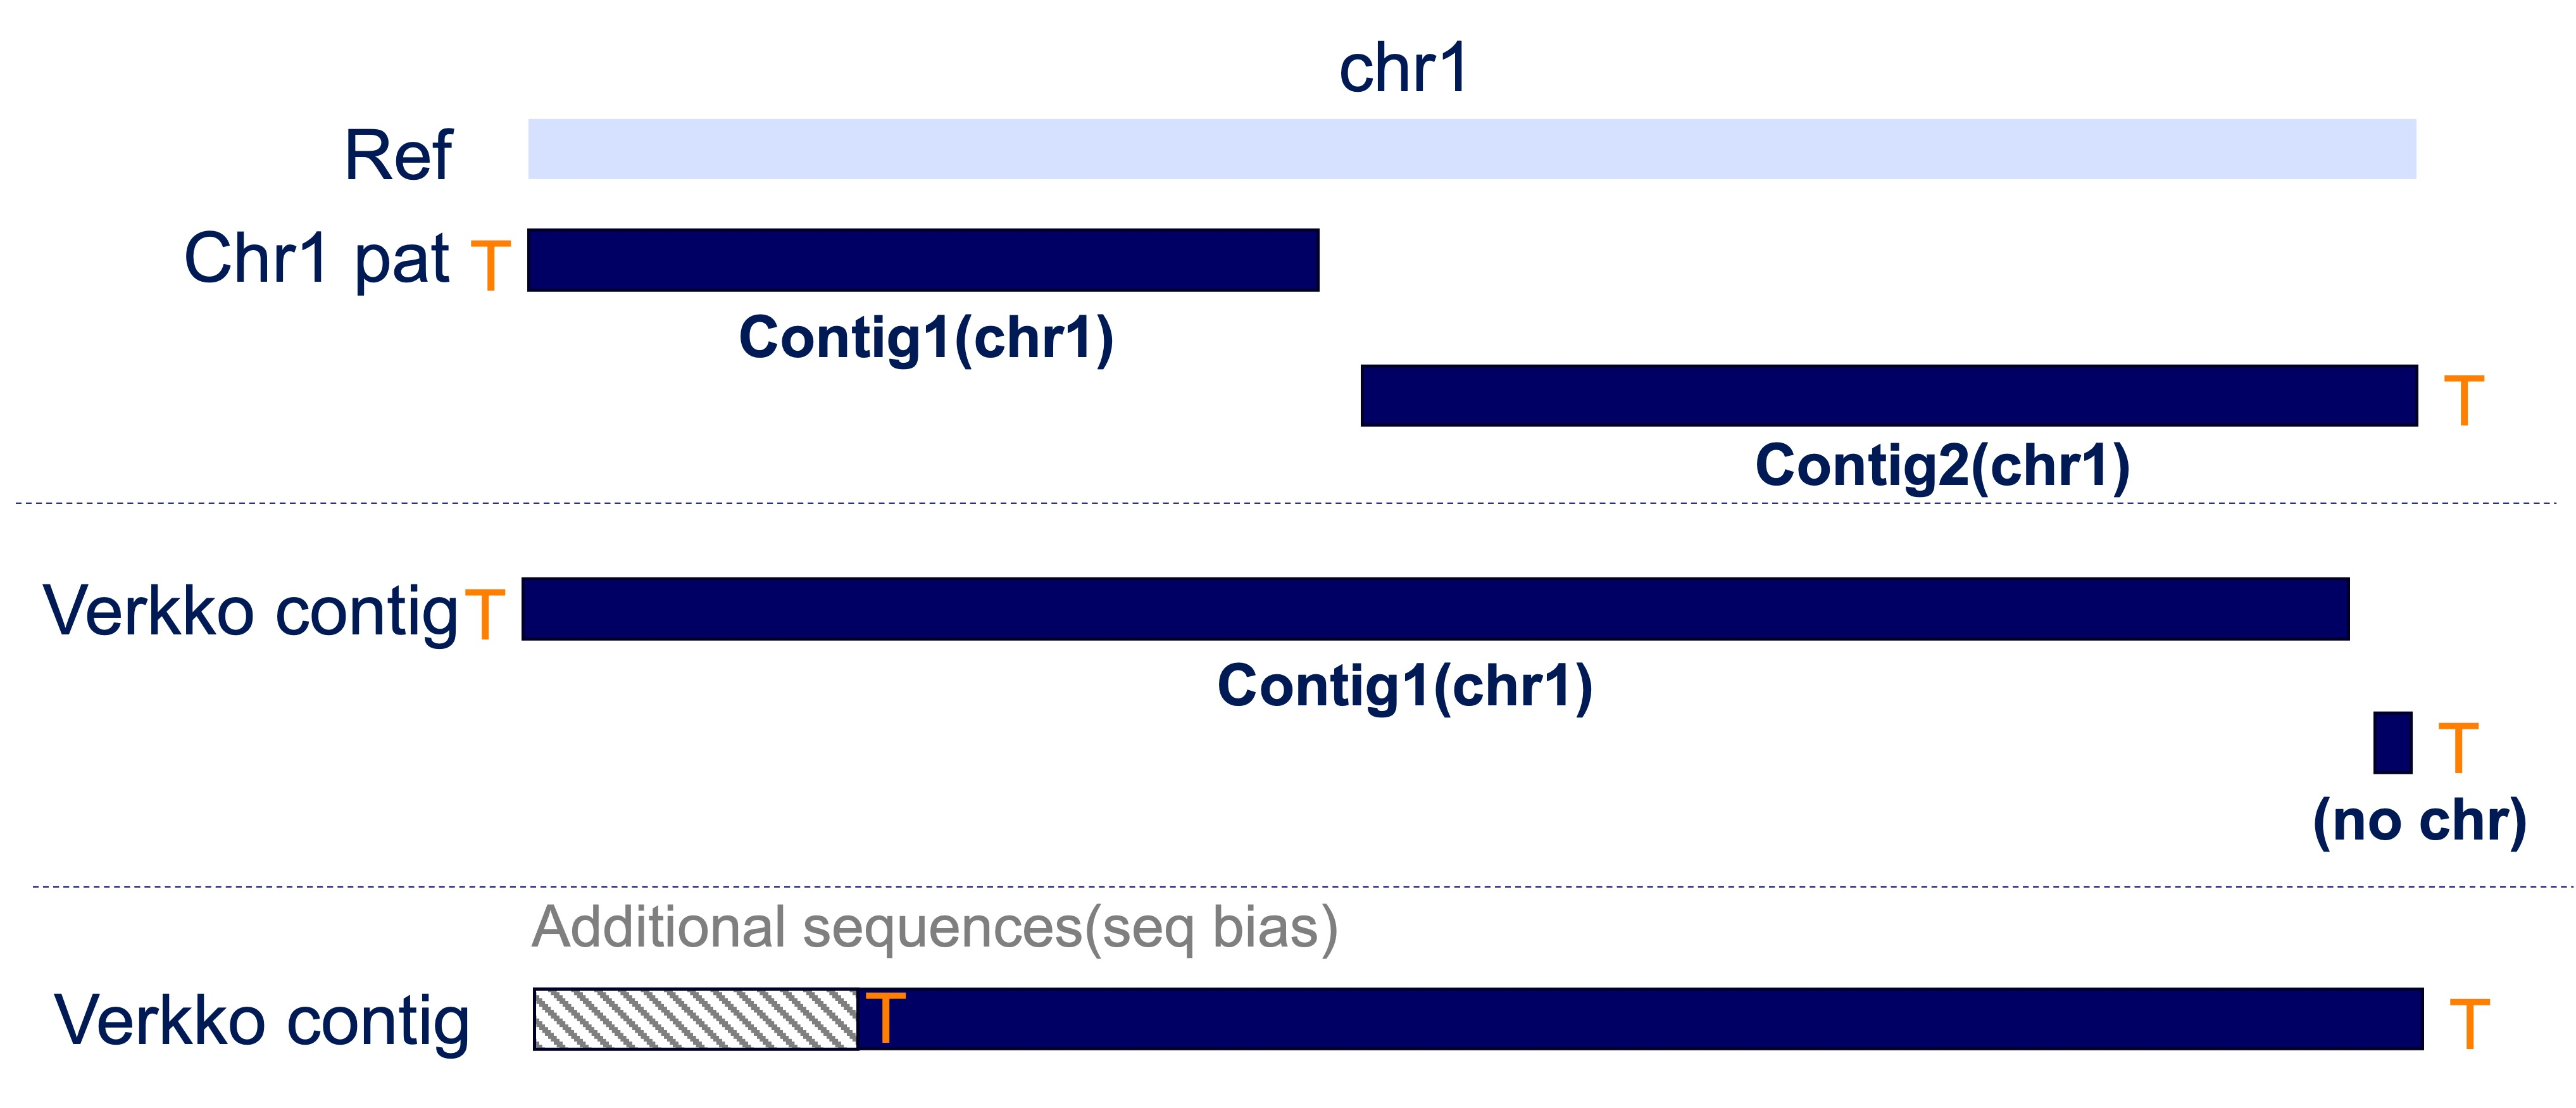

In [178]:
image_path = os.path.dirname(vf.__file__) + "/data/test_giraffe/fig/missingTel.jpg"
display(Image(filename=image_path,width=1000))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



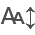

/path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_verkko_fillet
verkko-fillet version:0.1.12


In [170]:
%load_ext autoreload
%autoreload 2

import sys 
import importlib
import pandas as pd
import time
import os
from IPython.display import Image, display
pd.set_option('mode.chained_assignment', None)
import matplotlib.pyplot as plt
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import warnings
import session_info
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
import tqdm
from importlib import reload
print(os.getcwd())
sys.path.append('/data/Phillippy/projects/giraffeT2T/assembly/script/verkko-fillet/src')
import verkkofillet as vf
vf = reload(vf)

In [3]:
verkkoDir = '/path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic'
obj = vf.pp.read_Verkko(verkkoDir)
print(obj.verkko_fillet_dir)
os.chdir(obj.verkko_fillet_dir)

The Verkko fillet target directory already exists: /path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_verkko_fillet
If you didn't mean this, please set another directory or for overwirting, please use force= True
Lock the original Verkko folder to prevent it from being modified.
[lock_original_folder] Command executed successfully!
Path file loading...from /path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_verkko_fillet/assembly.paths.tsv
Path file loaded successfully.
scfmap file loading...from /path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_verkko_fillet/assembly.scfmap
scfmap file loaded successfully.
/path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_verkko_fillet


In [4]:
obj = vf.pp.findGaps(obj)

45 gaps were found -> obj.gaps


In [5]:
map_file= "/path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_legacy/chromosome.map"
obj = vf.pp.readChr(obj, map_file, sire = "pat", dam = "mat")

The chromosome infomation was stored in obj.stats


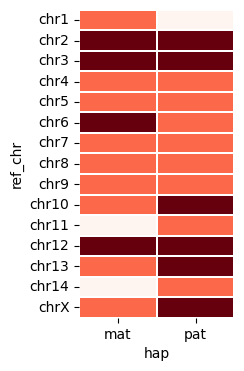

In [6]:
vf.pl.contigPlot(obj,plot_height = 4 , plot_width = 2)

Here, we have three contigs missing one of telomeres: chr11_mat, chr14_mat, and chr1_pat.

## Finding broken contigs

Using the `vf.pp.detectBrokenContigs()` function, you can identify chromosomes that have more than two contigs from the same haplotype. This indicates that Verkko generated two distinct contigs, each long enough to be assigned to a chromosome, even though they originally belonged to a single contig.

In the giraffe genome, this issue occurs in the complex repeat and loop region in the middle of chr1 for the paternal haplotype.

In [24]:
vf.pp.detectBrokenContigs(obj)

  ref_chr hap_verkko  contig
0    chr1       sire       2


In [26]:
obj.stats.loc[obj.stats['ref_chr'] == 'chr1']

contig ref_chr  contig_len  ref_chr_len  hap  \
0   dam_compressed.k31.hapmer-0000009    chr1   225503047    210919050  mat   
1  sire_compressed.k31.hapmer-0000240    chr1   112764680    210919050  pat   
2  sire_compressed.k31.hapmer-0000243    chr1   117607670    210919050  pat   

      old_chr  completeness hap_verkko  t2tStat  
0  CM029949.1      106.9140        dam      scf  
1  CM029949.1       55.7596       sire  not_t2t  
2  CM029949.1       55.7596       sire  not_t2t

In [35]:
brokenContigs_chr1_pat_contigName = ['sire_compressed.k31.hapmer-0000240','sire_compressed.k31.hapmer-0000243']

In [36]:
obj.scfmap[obj.scfmap['contig'].isin(brokenContigs_chr1_pat_contigName)]

contig  \
779  sire_compressed.k31.hapmer-0000240   
798  sire_compressed.k31.hapmer-0000243   

                                       pathName  
779  sire_compressed.k31.hapmer_from_utig4-1445  
798  sire_compressed.k31.hapmer_from_utig4-1859

If we examine the paths of each contig, we can see that the breakage occurs between `utig-842` and `utig-1577`.

In [39]:
brokenContigs_chr1_pat_pathName=['sire_compressed.k31.hapmer_from_utig4-1445','sire_compressed.k31.hapmer_from_utig4-1859']
obj.paths.loc[obj.paths['name'].isin(brokenContigs_chr1_pat_pathName)]

name  \
254  sire_compressed.k31.hapmer_from_utig4-1445   
257  sire_compressed.k31.hapmer_from_utig4-1859   

                                                  path  \
254  utig4-754-,utig4-750-,utig4-751+,utig4-1346+,u...   
257  utig4-1577-,[N50039N:tangle],utig4-1576+,utig4...   

                     assignment  
254  SIRE_COMPRESSED.K31.HAPMER  
257  SIRE_COMPRESSED.K31.HAPMER

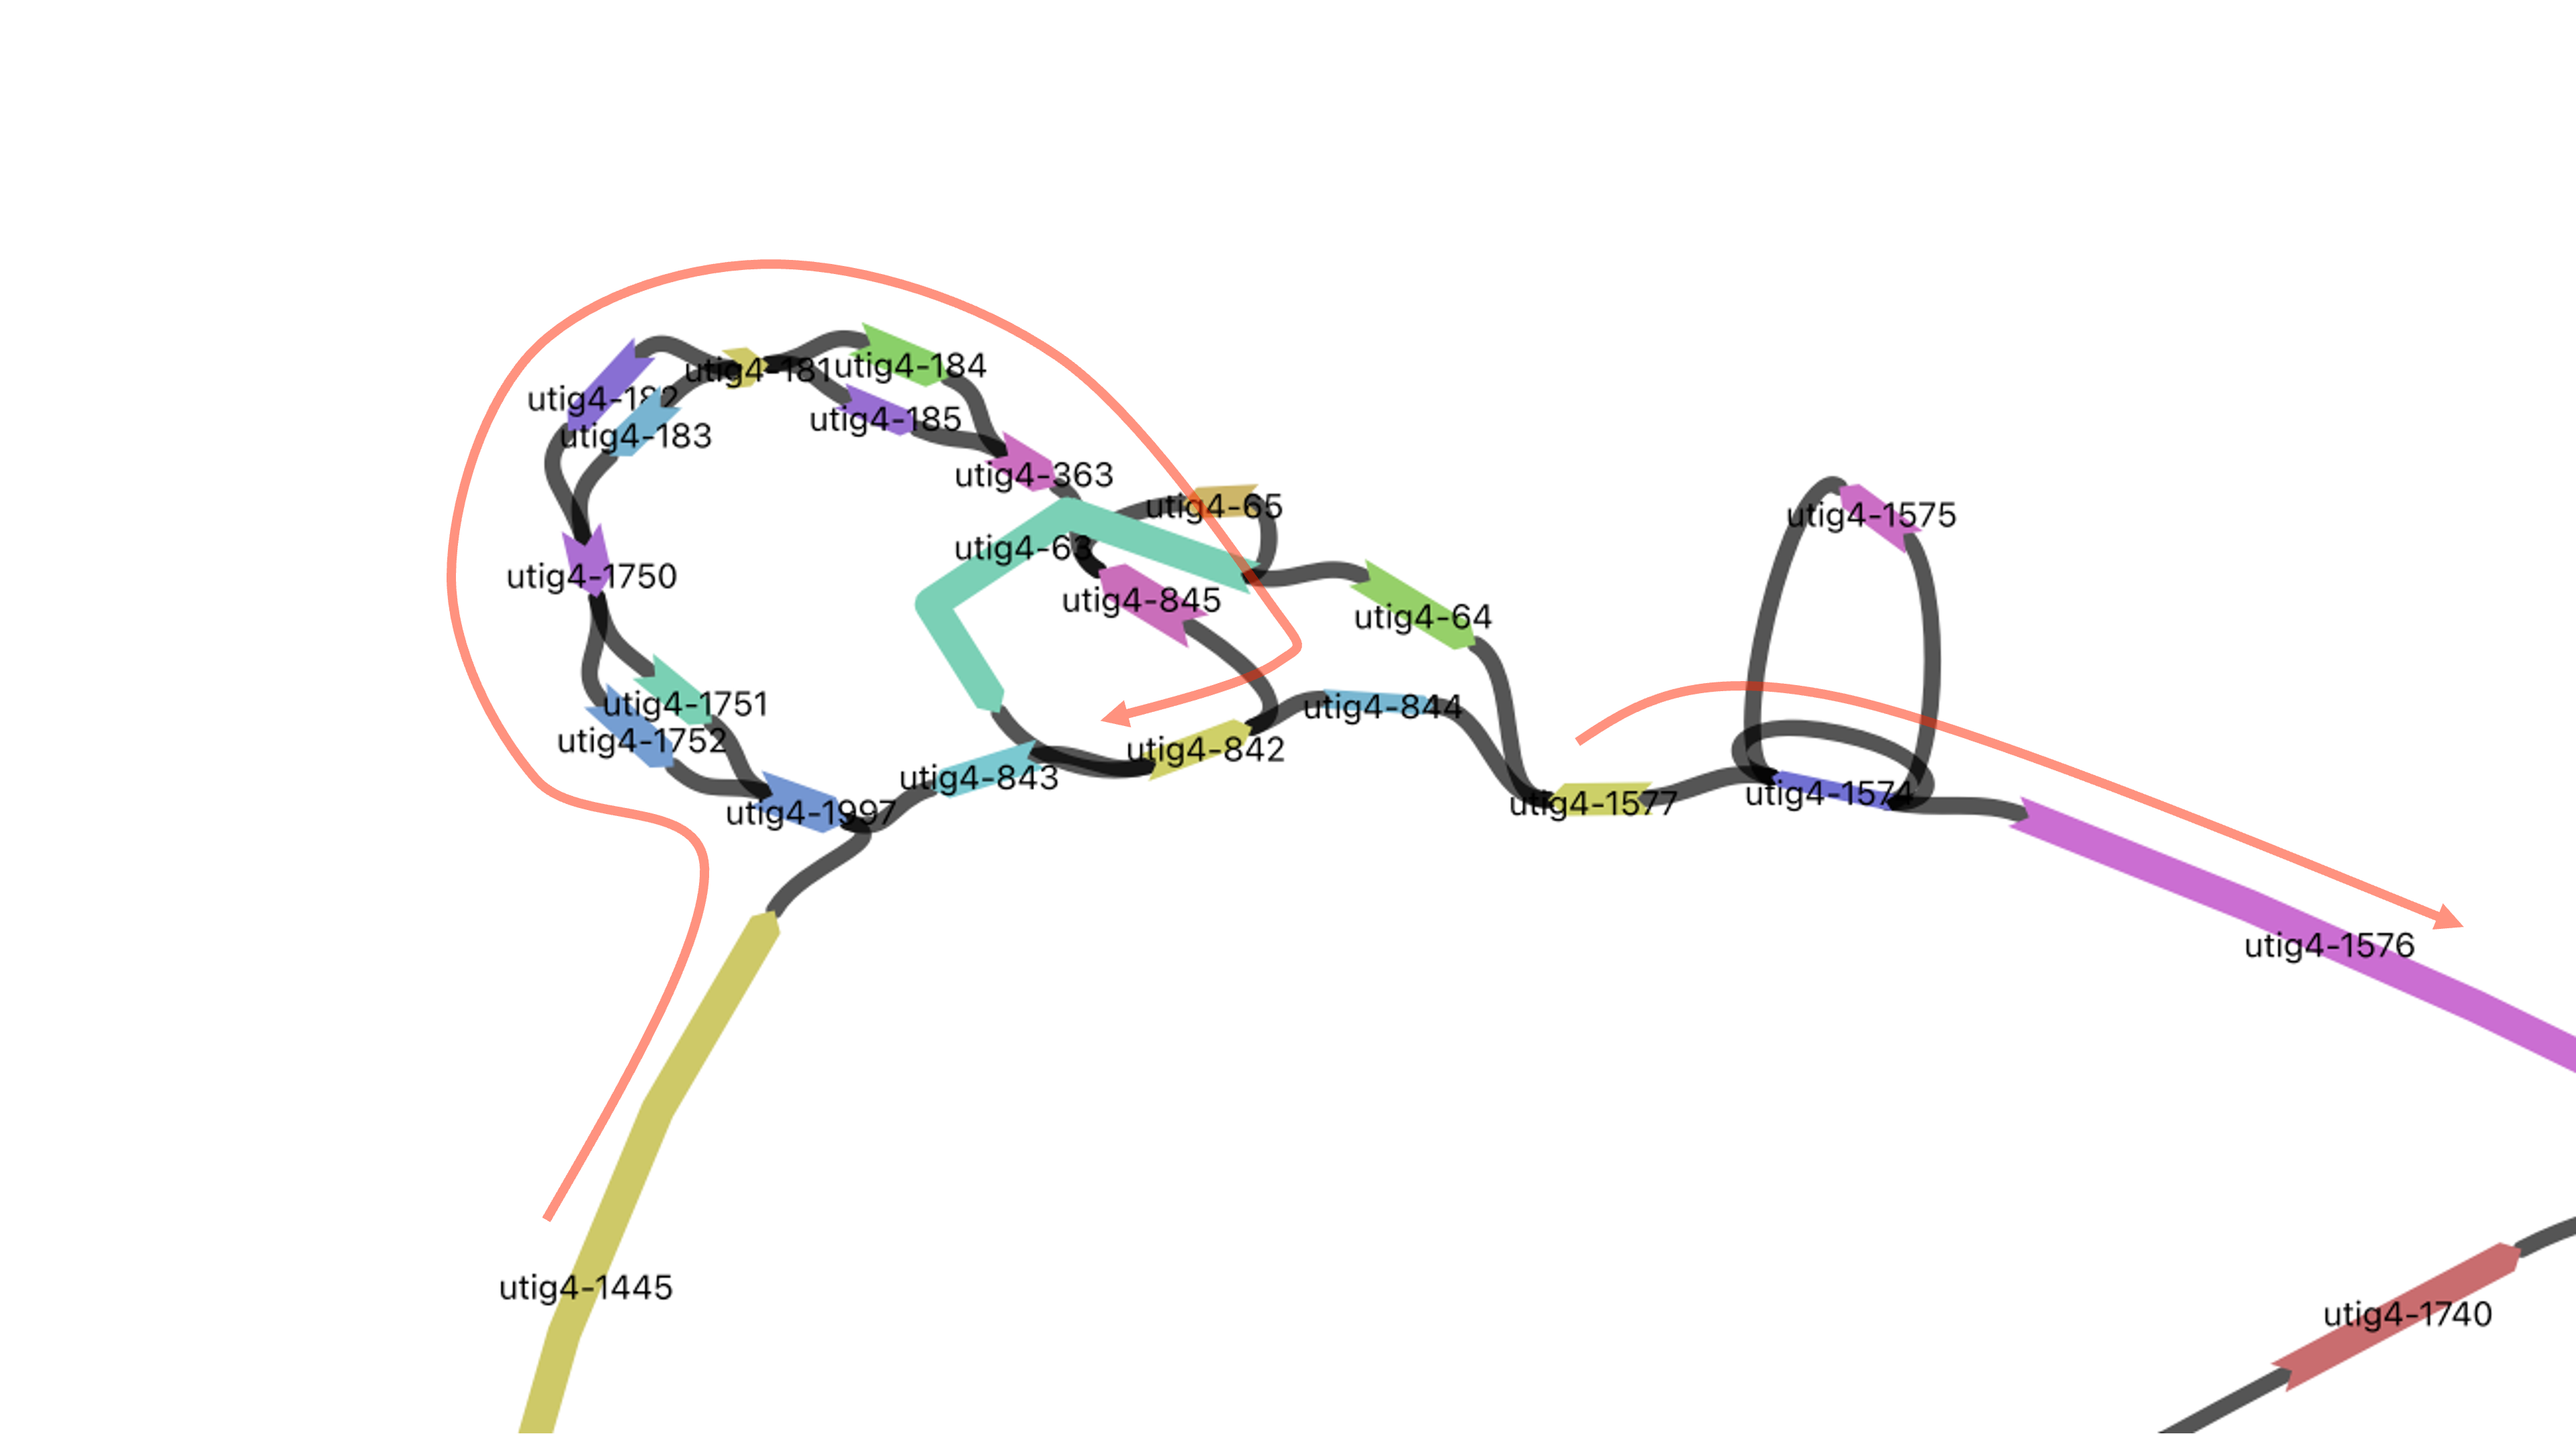

In [44]:
image_path = os.path.dirname(vf.__file__) + "/data/test_giraffe/fig/pat_chr1_brokenContig.png"
display(Image(filename=image_path,width=1000))

We are going to connect these two paths by inserting a new gap of 5 kb. Before doing so, here is the current state of `obj.gaps`:

In [21]:
obj.gaps.tail(2)

gapId                                       name  \
0  gapid_43  sire_compressed.k31.hapmer_from_utig4-557   
1  gapid_44  sire_compressed.k31.hapmer_from_utig4-557   

                                                gaps notes fixedPath  \
0  [utig4-1578+, [N9861N:ambig_bubble], utig4-2295+]                   
1     [utig4-923+, [N5000N:ambig_path], utig4-1685+]                   

  startMatch endMatch finalGaf done  
0                                    
1

The `vf.pp.connectContigs()` function is used to merge contigs that are separated by gaps. This function takes the following arguments:

* `contig`: The contig to be connected.
* `contig_to`: The target contig to which it will be connected.
* `at`: The position where the contig should be connected to contig_to.
* `flip`: Set to True if you want to flip the contig.
* `fix_path`: Set to True if you want to update `obj.path`. We don't recommend update this.

In this example, we will connect `sire_compressed.k31.hapmer_from_utig4-1445` to the left side (beginning) of `sire_compressed.k31.hapmer_from_utig4-1859` using a new gap named `[N5000N:insertGap]`, without flipping the `contig`. 

You can directly check how the new gap has been added to the `obj.gaps` database.

If you accidentally add incorrect gap information, you can remove it using the `vf.pp.deleteGap` function, as shown below. This example demonstrates how to create a new gap, remove an incorrect attempt, and then correct it.

In [22]:
path1 = "sire_compressed.k31.hapmer_from_utig4-1445" # from
path2 = "sire_compressed.k31.hapmer_from_utig4-1859" # to
gap = "[N5000N:insertGap]"
at = "right" # Wrong orientation for testing
flip = False 
fix_path = False

obj = vf.pp.connectContigs(obj, contig= path1, contig_to= path2, at = at, gap = gap, flip = flip, fix_path = fix_path)
obj.gaps.tail(2)

Connected sire_compressed.k31.hapmer_from_utig4-1445 to sire_compressed.k31.hapmer_from_utig4-1859 at right with flip False
sire_compressed.k31.hapmer_from_utig4-1445 was merged to sire_compressed.k31.hapmer_from_utig4-1859 in obj.paths
sire_compressed.k31.hapmer_from_utig4-1445 was replaced with sire_compressed.k31.hapmer_from_utig4-1859 in obj.gaps
New gap was added to obj.gaps with gapId gapid_45


gapId                                        name  \
44  gapid_44   sire_compressed.k31.hapmer_from_utig4-557   
45  gapid_45  sire_compressed.k31.hapmer_from_utig4-1859   

                                              gaps  \
44  [utig4-923+, [N5000N:ambig_path], utig4-1685+]   
45                                       endMarker   

                                                notes  \
44                                                      
45  connected sire_compressed.k31.hapmer_from_utig...   

                                            fixedPath startMatch endMatch  \
44                                                                          
45  endMarker,[N5000N:insertGap],utig4-754-,utig4-...                       

   finalGaf  done  
44                 
45           True

In [23]:
gapId = 'gapid_45'

obj = vf.pp.deleteGap(obj, gapId)

In [24]:
path1 = "sire_compressed.k31.hapmer_from_utig4-1445" # from
path2 = "sire_compressed.k31.hapmer_from_utig4-1859" # to
gap = "[N5000N:insertGap]"
at = "left" 
flip = False 
fix_path = False

obj = vf.pp.connectContigs(obj, contig= path1, contig_to= path2, at = at, gap = gap, flip = flip, fix_path = fix_path)
obj.gaps.tail(2)

Connected sire_compressed.k31.hapmer_from_utig4-1445 to sire_compressed.k31.hapmer_from_utig4-1859 at left with flip False
sire_compressed.k31.hapmer_from_utig4-1445 was merged to sire_compressed.k31.hapmer_from_utig4-1859 in obj.paths
sire_compressed.k31.hapmer_from_utig4-1445 was replaced with sire_compressed.k31.hapmer_from_utig4-1859 in obj.gaps
New gap was added to obj.gaps with gapId gapid_45


gapId                                        name  \
44  gapid_44   sire_compressed.k31.hapmer_from_utig4-557   
45  gapid_45  sire_compressed.k31.hapmer_from_utig4-1859   

                                              gaps  \
44  [utig4-923+, [N5000N:ambig_path], utig4-1685+]   
45                                     startMarker   

                                                notes  \
44                                                      
45  connected sire_compressed.k31.hapmer_from_utig...   

                                            fixedPath startMatch endMatch  \
44                                                                          
45  utig4-754-,utig4-750-,utig4-751+,utig4-1346+,u...                       

   finalGaf  done  
44                 
45           True

## Finding counterpart haplotypes' chromosome for the broken short nodes

We also have a node that wasn’t assigned to any chromosome due to its short length and lack of connections to other contigs.

In this case, we will align this node to the sequences of other nodes, excluding self-alignment, to identify a corresponding node from the other haplotype. By finding a node from the other haplotype within an intact contig that has a chromosome assignment, we can determine the correct chromosome for this unassigned node and then connect it to the main contig.

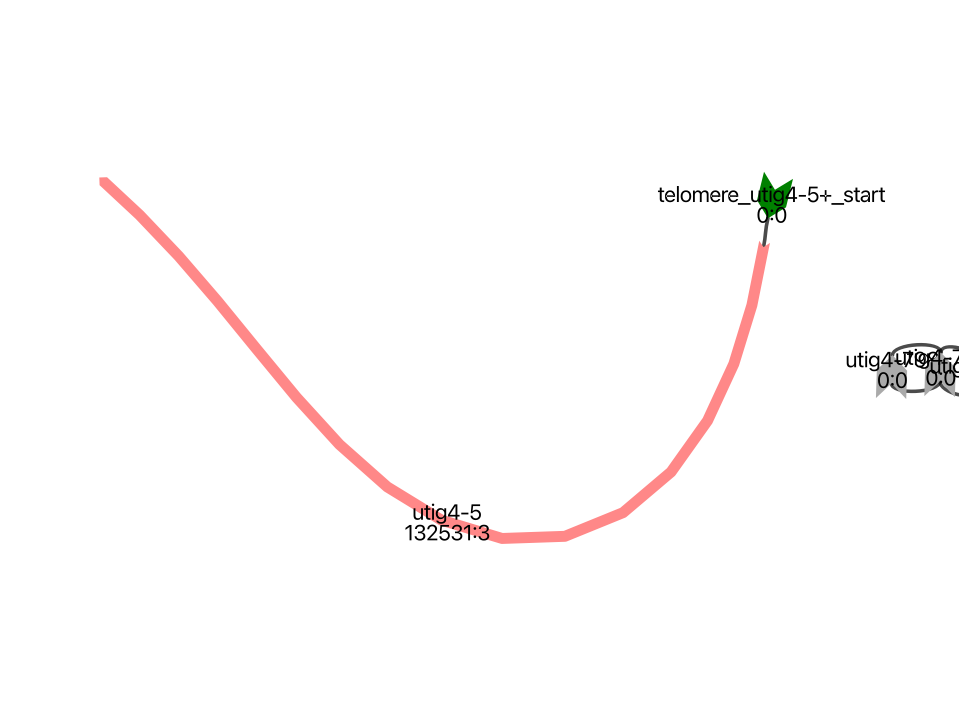

In [113]:
image_path = os.path.dirname(vf.__file__) + "/data/test_giraffe/fig/utig4-5_mat.png"
display(Image(filename=image_path,width=500))

Before aligning the node, we need to generate a FASTA file from the graph (.gfa) file. You can use the following command to generate the FASTA file from the graph file:

In [34]:
%%time
vf.tl.gfaToFasta(gfa = "assembly.homopolymer-compressed.gfa", out_fasta=None)

Converting assembly.homopolymer-compressed.gfa to FASTA format
assembly.homopolymer-compressed.fasta already exists
CPU times: user 317 µs, sys: 318 µs, total: 635 µs
Wall time: 1.07 ms


If you have node's fasta file, you can use it as input fasta file. Otherwise, you can use the output fasta file from the above command to pairwise align the contigs.

In [37]:
%%time
vf.tl.mapBetweenNodes(query = "graphAlignment/utig4-5.fa", threads=50, out=None, showOnly=False,
                working_directory="chromosome_assignment")

aligning assembly.homopolymer-compressed.fasta to graphAlignment/utig4-5.fa
Reference: /path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_verkko_fillet/assembly.homopolymer-compressed.fasta
Query: /path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_verkko_fillet/graphAlignment/utig4-5.fa
Output: assembly.homopolymer-compressed_vs_utig4-5.mashmap.out
Indexing reference fasta file
[mapBetNodes] Command executed successfully!
[convertRefName] Command executed successfully!
CPU times: user 7.23 ms, sys: 9.52 ms, total: 16.8 ms
Wall time: 4min 35s


Once the FASTA file is generated, we can determine which node in the graph is the best match for the query sequence.

In this example, the `utig4-5` (maternal) node was mapped to the paternal node `utig4-1804` and the node in the chr14_pat contig. When examining the chr14, we observe clusters of rDNA nodes at the end of the contig for both haplotypes. However, the paternal contig has an additional node with a telomere node, which indicates the correct chromosome assignment for this sequence.

File figs/mashmap.utig4-5_top10_blocksize.png already exists
Please remove the file or change the name


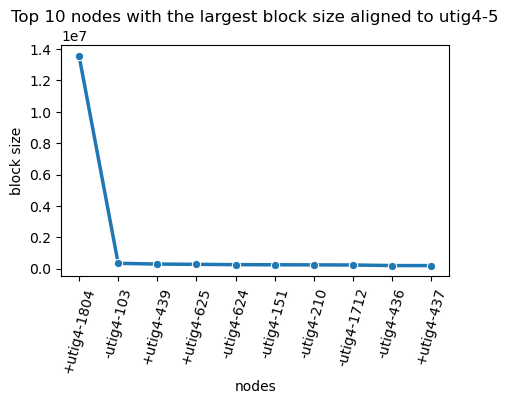

In [64]:
vf.pl.nodeMashmapBlockSize(mashmap_out = "chromosome_assignment/assembly.homopolymer-compressed_vs_utig4-5.mashmap.out",
                           node = "utig4-5",
                           width = 5,
                           height = 3)

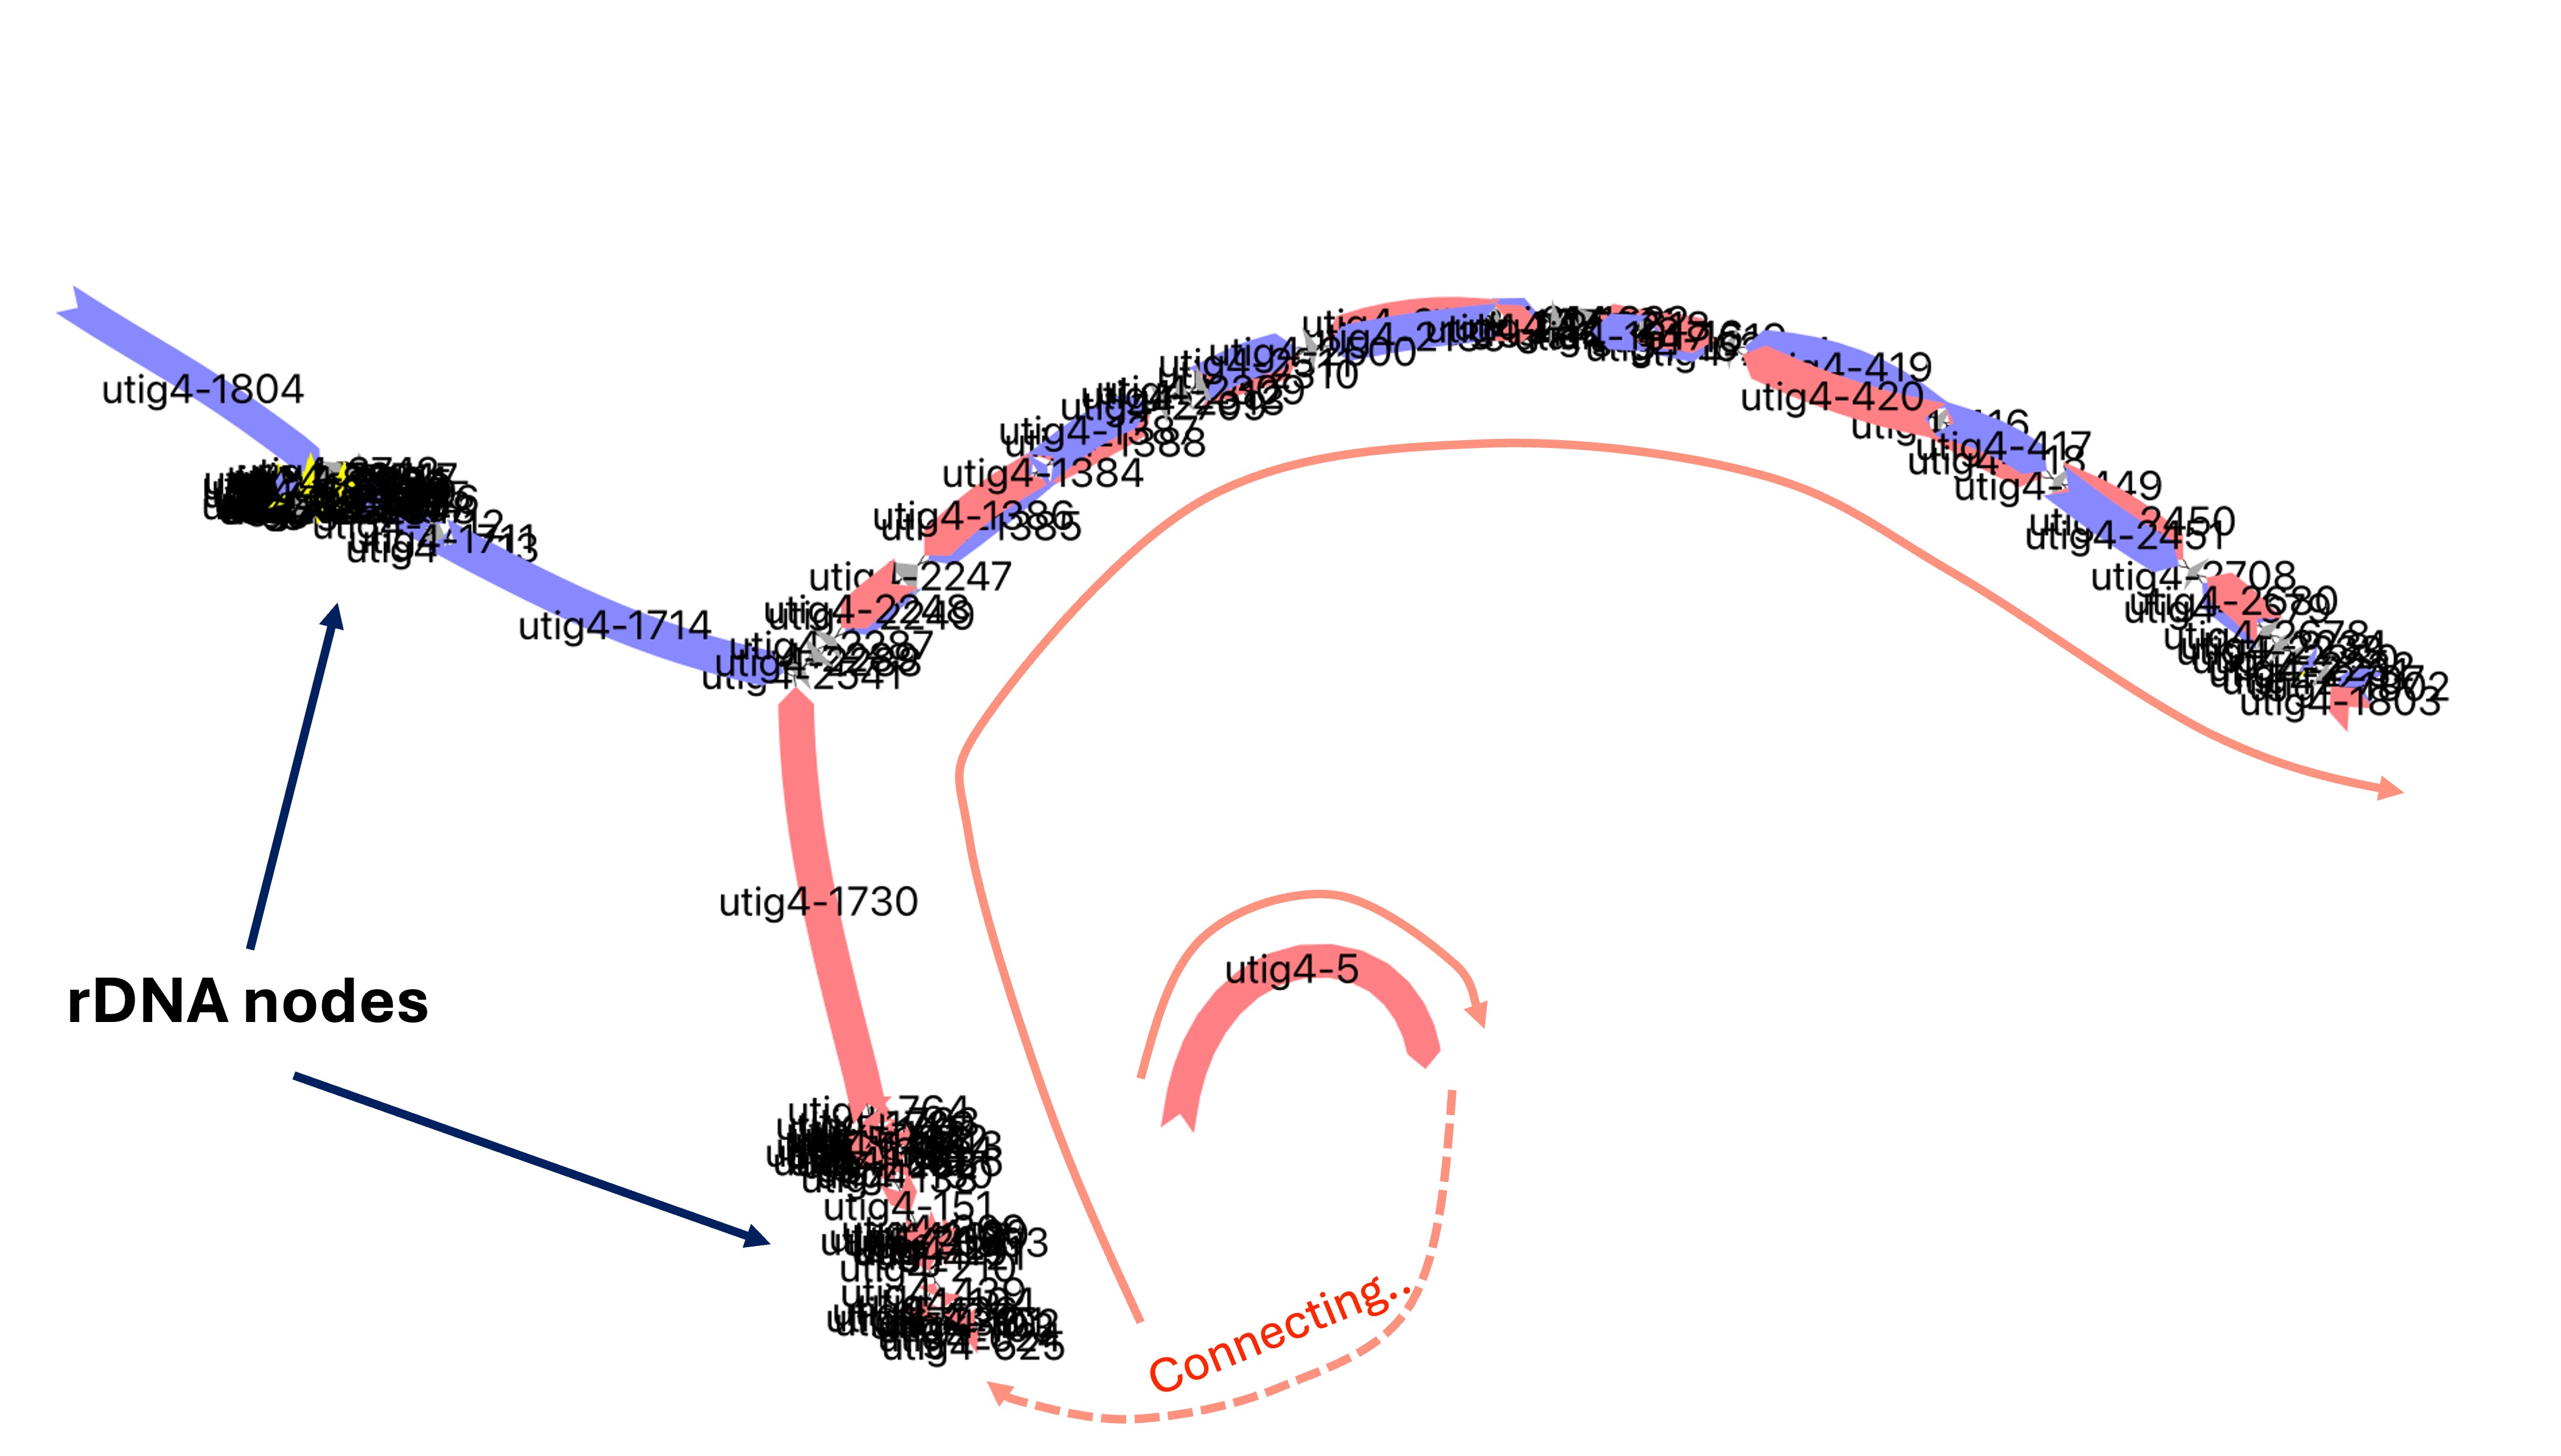

In [184]:
image_path = os.path.dirname(vf.__file__) + "/data/test_giraffe/fig/chr14.jpg"
display(Image(filename=image_path,width=1200))

In [91]:
vf.pp.highlight_nodes(obj, node = "utig4-5+")

name,path
haplotype2_from_utig4-5,utig4-5+


In [183]:
vf.pp.highlight_nodes(obj, node = "utig4-1730+")

name,path
dam_compressed.k31.hapmer_from_utig4-1730,"utig4-436-,utig4-439+,utig4-210-,[N572862N:tangle],utig4-151-,[N685960N:tangle],utig4-1730+,utig4-2541+,utig4-2288-,utig4-2287+,utig4-2248-,utig4-2247+,utig4-1386-,utig4-1384+,utig4-1388+,utig4-2709+,utig4-2313-,utig4-2309-,utig4-2310+,utig4-2500+,utig4-2138-,utig4-2137+,utig4-2140+,utig4-2532+,utig4-1621-,utig4-1618-,utig4-1616+,utig4-1619+,utig4-2531-,utig4-420-,utig4-416-,utig4-418+,utig4-2449-,utig4-2450+,utig4-2708-,utig4-2680-,utig4-2678-,utig4-2233-,utig4-2230-,utig4-2231+,utig4-2707+,utig4-1803-"


Since the orientation is the same, we can connect the nodes without flipping.

In [109]:
path1 = "haplotype2_from_utig4-5" # from
path2 = "dam_compressed.k31.hapmer_from_utig4-1730" # to
gap = "[N5000N:insertGap]"
at = "left" # or "right" at path1
flip = False # or True of path2
fix_path = False # if true, the obj.paths will be updated

obj = vf.pp.connectContigs(obj, contig= path1, contig_to= path2, at = at, gap = gap, flip = flip, fix_path = fix_path)
obj.gaps.tail(2)

Connected haplotype2_from_utig4-5 to dam_compressed.k31.hapmer_from_utig4-1730 at left with flip False
haplotype2_from_utig4-5 was merged to dam_compressed.k31.hapmer_from_utig4-1730 in obj.paths
haplotype2_from_utig4-5 was replaced with dam_compressed.k31.hapmer_from_utig4-1730 in obj.gaps
New gap was added to obj.gaps with gapId gapid_45


gapId                                       name  \
44  gapid_44  sire_compressed.k31.hapmer_from_utig4-557   
45  gapid_45  dam_compressed.k31.hapmer_from_utig4-1730   

                                              gaps  \
44  [utig4-923+, [N5000N:ambig_path], utig4-1685+]   
45                                     startMarker   

                                                notes  \
44                                                      
45  connected haplotype2_from_utig4-5 to dam_compr...   

                                  fixedPath startMatch endMatch finalGaf  done  
44                                                                              
45  utig4-5+,[N5000N:insertGap],startMarker                               True

## Finding interal telomerem

If you use HiFi and Dorado reads to build consensus sequences, there is a chance that ONT data extends beyond the true telomere sequences.

In this case, you can use the following functions to identify internal telomere sequences and confirm this by comparing the telomere percentage between internal telomere regions and the telomere sequences at the end of the contig.

Additionally, you can analyze the composition of HiFi and ONT reads at the beginning of the contig—especially if it appears to be an artifact—to check for any sequencing platform bias.

In [173]:
# vf.tl.detect_internal_telomere(obj)
intra_telo, tel =  vf.pp.find_intra_telo(obj)

intra_telo

Finding the internal telomeres in the assembly...
Reading file: /path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_verkko_fillet/internal_telomere/assembly_1/assembly.windows
Number of internal telomeres: 3
File saved: /path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_verkko_fillet/internal_telomere/assembly_1/assembly.windows.loc_from_end_15000.teloPerct_0.5.telolen_0.stats.tsv


contig  internal-left  internal-right  \
0    dam_compressed.k31.hapmer-0000009          0.000           0.000   
1   sire_compressed.k31.hapmer-0000240          0.000           0.000   
2   sire_compressed.k31.hapmer-0000243          0.000           0.000   
3    dam_compressed.k31.hapmer-0000005          0.000           0.000   
4   sire_compressed.k31.hapmer-0000238          0.000           0.000   
5    dam_compressed.k31.hapmer-0000002          0.552           0.000   
6   sire_compressed.k31.hapmer-0000235          0.000           0.000   
7    dam_compressed.k31.hapmer-0000010          0.000           0.000   
8   sire_compressed.k31.hapmer-0000244          0.000           0.000   
9    dam_compressed.k31.hapmer-0000011          0.000           0.000   
10  sire_compressed.k31.hapmer-0000245          0.000           0.000   
11   dam_compressed.k31.hapmer-0000008          0.000           0.000   
12  sire_compressed.k31.hapmer-0000242          0.000           0.000   
13   dam_compressed.k31.hapmer-0000003          0.000           0.000   
14  sire_compressed.k31.hapmer-0000236          0.000           0.000   
15   dam_compressed.k31.hapmer-0000015          0.000           0.000   
16  sire_compressed.k31.hapmer-0000250          0.000           0.000   
17   dam_compressed.k31.hapmer-0000006          0.000           0.534   
18  sire_compressed.k31.hapmer-0000239          0.000           0.510   
19   dam_compressed.k31.hapmer-0000001          0.000           0.000   
20  sire_compressed.k31.hapmer-0000234          0.000           0.000   
21   dam_compressed.k31.hapmer-0000004          0.000           0.000   
22  sire_compressed.k31.hapmer-0000237          0.000           0.000   
23   dam_compressed.k31.hapmer-0000012          0.000           0.000   
24  sire_compressed.k31.hapmer-0000246          0.000           0.000   
25   dam_compressed.k31.hapmer-0000013          0.000           0.000   
26  sire_compressed.k31.hapmer-0000247          0.000           0.000   
27   dam_compressed.k31.hapmer-0000014          0.000           0.000   
28  sire_compressed.k31.hapmer-0000248          0.000           0.000   
29   dam_compressed.k31.hapmer-0000007          0.000           0.000   
30  sire_compressed.k31.hapmer-0000241          0.000           0.000   

    non-internal-left  non-internal-right           problem ref_chr  \
0               0.592               0.546          OK/INTEL    chr1   
1               0.957               0.000  MissingTel/INTEL    chr1   
2               0.000               0.527  MissingTel/INTEL    chr1   
3               0.974               0.523          OK/INTEL   chr10   
4               0.984               0.509          OK/INTEL   chr10   
5               0.000               0.578  MissingTel/INTEL   chr11   
6               0.967               0.522          OK/INTEL   chr11   
7               0.979               0.542          OK/INTEL   chr12   
8               0.984               0.513          OK/INTEL   chr12   
9               0.975               0.574          OK/INTEL   chr13   
10              0.980               0.554          OK/INTEL   chr13   
11              0.000               0.550  MissingTel/INTEL   chr14   
12              0.996               0.586          OK/INTEL   chr14   
13              0.986               0.577          OK/INTEL    chr2   
14              0.986               0.562          OK/INTEL    chr2   
15              0.973               0.558          OK/INTEL    chr3   
16              0.965               0.537          OK/INTEL    chr3   
17              0.988               0.588          OK/INTEL    chr4   
18              0.990               0.520          OK/INTEL    chr4   
19              0.973               0.538          OK/INTEL    chr5   
20              0.873               0.533          OK/INTEL    chr5   
21              0.979               0.609          OK/INTEL    chr6   
22              0.985               0.611          OK/INTEL   

File figs/intra_telo.heatmap.png already exists
Please remove the file or change the name


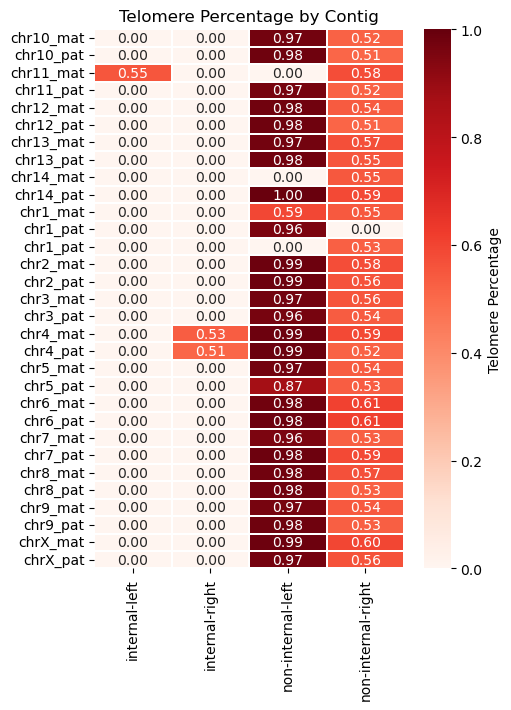

In [175]:
vf.pl.percTel(intra_telo, showContig  = ['ref_chr','hap'])

Here, we found a total of three internal telomere sequences from chr11_mat, chr4_mat, and chr4_pat.

However, both haplotypes of chr4 already have a real telomere at the right end of the contig. (Since we don't yet know which side corresponds to the p or q arm, we refer to them as left and right.)

To further investigate chr11_mat, we will use the `vf.pp.find_reads_intra_telo()` function to identify which reads were used to the consensus sequence beyond the telomere regions.

In [186]:
vf.pp.find_reads_intra_telo(tel, 2 ,scfmap = "assembly.scfmap",layout = "6-layoutContigs/unitig-popped.layout")

Finding the reads support for the additional artifical sequences outside of the telomere...
Looking for the reads from start of dam_compressed.k31.hapmer-0000002
Looking for the reads from piece000003
Summary : 
   Num of ONT reads : 6
   Num of HiFi reads : 12


readName  start_hpc  end_hpc  \
0   77cea7cb-9a53-49ed-9b8c-8b619f080b2f;779e7008-...          0    21521   
1               m84124_230828_171016_s1/226366877/ccs       1524    21308   
2                m84124_231207_004036_s4/68551224/ccs       3981    26335   
3               m84124_230821_162704_s3/155325965/ccs       4720    18750   
4   5c63b8eb-458b-4775-ba6a-e2058c914931;d3f9945c-...       4725    30928   
5   42d32072-2205-4c8a-af90-8d268386f70d;7a9861ba-...       5007    70501   
6   d381081f-1035-4ab0-a330-ab0c2132c00c;ea8cea12-...       5447    23510   
7               m84124_230830_170956_s3/118821981/ccs       6240    18399   
8               m84124_230818_165616_s1/233444613/ccs       6418    22234   
9   97bb03c2-a447-4914-ad6c-0c44d6ff2d85;c5440667-...       7733    31930   
10              m84124_230830_170956_s3/128717258/ccs       7759    27578   
11              m84124_230818_165616_s1/104075007/ccs       8327    23802   
12  770537c7-8438-4486-9e99-15f952d58a30;f826e618-...      43309     9861   
13              m84124_230828_171016_s1/121833470/ccs      20443     9891   
14              m84124_230828_171016_s1/133368988/ccs      10149    19411   
15              m84124_230731_175605_s1/241174499/ccs      10809    26377   
16               m84124_230828_171016_s1/74715993/ccs      11652    23662   
17              m84124_230830_170956_s3/225514342/ccs      27014    12431   

      start       end  type  
0       0.0   32281.5   ont  
1    2286.0   31962.0  hifi  
2    5971.5   39502.5  hifi  
3    7080.0   28125.0  hifi  
4    7087.5   46392.0   ont  
5    7510.5  105751.5   ont  
6    8170.5   35265.0   ont  
7    9360.0   27598.5  hifi  
8    9627.0   33351.0  hifi  
9   11599.5   47895.0   ont  
10  11638.5   41367.0  hifi  
11  12490.5   35703.0  hifi  
12  14791.5   64963.5   ont  
13  14836.5   30664.5  hifi  
14  15223.5   29116.5  hifi  
15  16213.5   39565.5  hifi  
16  17478.0   35493.0  hifi  
17  18646.5   40521.0  hifi

We have well-balanced sequencing coverage across the region from the telomere to the internal telomere for chr11_mat, so trimming this region is not necessary.